In [1]:
import pandas as pd

# Load your cleaned data using full path
df = pd.read_csv("/Users/keyannadavis/cleaned_nps_species_data.csv")

# Preview first few rows
df.head()

,ParkCode,ParkName,CategoryName,Order,Family,TaxonRecordStatus,SciName,CommonNames,ParkAccepted,Sensitive,RecordStatus,Occurrence,Nativeness,Abundance,References,Observations,Vouchers,TEStatus,GRank,HasTEStatus
0,ACAD,Acadia National Park,Mammal,Artiodactyla,Cervidae,Active,Alces alces,Moose,True,False,Approved,Present,Native,Rare,11,1,0,50,G5,1
1,ACAD,Acadia National Park,Mammal,Artiodactyla,Cervidae,Active,Odocoileus virginianus,"Northern White-tailed Deer, Virginia Deer, Whi...",True,False,Approved,Present,Native,Abundant,20,0,0,50,G5,1
2,ACAD,Acadia National Park,Mammal,Carnivora,Canidae,Active,Canis latrans,"Coyote, Eastern Coyote",True,False,Approved,Present,Non-native,Common,8,1,0,SC,G5,1
3,ACAD,Acadia National Park,Mammal,Carnivora,Canidae,Active,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",True,False,Approved,Unconfirmed,Native,Unknown,2,0,0,E,G5,1
4,ACAD,Acadia National Park,Mammal,Carnivora,Canidae,Active,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",True,False,Approved,Present,Unknown,Common,16,0,0,NaN,G5,1


In [2]:
df.shape
df.columns


Index(['ParkCode', 'ParkName', 'CategoryName', 'Order', 'Family',
       'TaxonRecordStatus', 'SciName', 'CommonNames', 'ParkAccepted',
       'Sensitive', 'RecordStatus', 'Occurrence', 'Nativeness', 'Abundance',
       'References', 'Observations', 'Vouchers', 'TEStatus', 'GRank',
       'HasTEStatus'],
      dtype='object')

In [3]:
df['Nativeness'].value_counts(normalize=True)

Nativeness
Unknown       0.508955
Native        0.428651
Non-native    0.062394
Name: proportion, dtype: float64

In [4]:
df['Sensitive'].value_counts(normalize=True)

Sensitive
False    1.0
Name: proportion, dtype: float64

After reviewing the cleaned NPS dataset, Sensitive can’t be modeled (no variation), so I’ll focus on predicting Nativeness.
Because the data is moderately imbalanced and includes mixed feature types, I plan to use Gradient Boosting (XGBoost) as my modeling approach.

In [6]:
df_model = df[df['Nativeness'].isin(['Native', 'Non-native'])]

In [7]:
# --- 0) Imports ---
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split

# Optional: pretty display
pd.set_option("display.max_columns", 100)

In [8]:
# --- 1) Start from your loaded df and keep only Native / Non-native ---
# (do NOT modify original df in-place; create a copy for modeling)
df_model = df[df["Nativeness"].isin(["Native", "Non-native"])].copy()

# Create binary target: Native=0, Non-native=1
df_model["target"] = df_model["Nativeness"].map({"Native": 0, "Non-native": 1})

print(df_model["Nativeness"].value_counts())
print("\nProportions:\n", df_model["Nativeness"].value_counts(normalize=True).round(3))

Nativeness
Native        26182
Non-native     3811
Name: count, dtype: int64

Proportions:
 Nativeness
Native        0.873
Non-native    0.127
Name: proportion, dtype: float64


In [9]:
# --- 2) Quick sanity checks on missingness ---
# Nulls by column (sorted)
nulls = df_model.isna().sum().sort_values(ascending=False)
print("Nulls by column:\n", nulls.head(20))

# % missing overall
pct_missing = (df_model.isna().any(axis=1).mean() * 100)
print(f"\nRows with ANY missing value: {pct_missing:.2f}%")

Nulls by column:
 TEStatus             26638
GRank                 5771
CommonNames           2768
Order                  202
Family                 180
Occurrence               3
ParkCode                 0
Abundance                0
HasTEStatus              0
Vouchers                 0
Observations             0
References               0
RecordStatus             0
Nativeness               0
ParkName                 0
Sensitive                0
ParkAccepted             0
SciName                  0
TaxonRecordStatus        0
CategoryName             0
dtype: int64

Rows with ANY missing value: 89.94%


In [10]:
# --- 3) Define features (X) and target (y) ---
# Drop label columns and any IDs you don't want the model to use
drop_cols = ["target", "Nativeness"]  # add others if needed, e.g., "SciName"
X = df_model.drop(columns=drop_cols)
y = df_model["target"]

print("X shape:", X.shape, "| y shape:", y.shape)

X shape: (29993, 19) | y shape: (29993,)


In [11]:
from sklearn.model_selection import train_test_split
from collections import Counter

# --- Train/Test Split (70/30) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,       # 30% for testing
    random_state=42,     # reproducibility
    stratify=y           # maintain class balance
)

print("Train set size:", X_train.shape)
print("Test  set size:", X_test.shape)

print("\nClass balance:")
print("Train:", Counter(y_train))
print("Test :", Counter(y_test))

Train set size: (20995, 19)
Test  set size: (8998, 19)

Class balance:
Train: Counter({0: 18327, 1: 2668})
Test : Counter({0: 7855, 1: 1143})


Logistic Regression
ROC-AUC: 0.9514

Classification report:
               precision    recall  f1-score   support

           0      0.969     0.958     0.964      7855
           1      0.733     0.790     0.760      1143

    accuracy                          0.937      8998
   macro avg      0.851     0.874     0.862      8998
weighted avg      0.939     0.937     0.938      8998

Confusion matrix:
 [[7526  329]
 [ 240  903]]


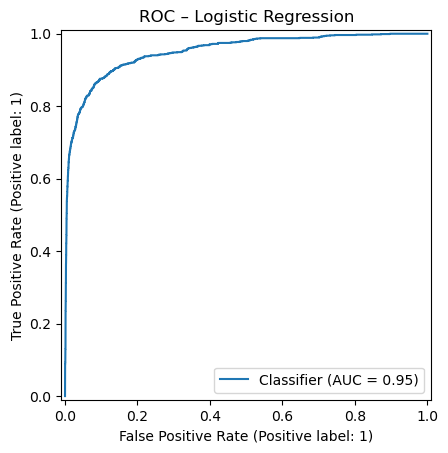

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1) Identify column types
num_cols = X_train.select_dtypes(include=["number", "bool"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=["number", "bool"]).columns.tolist()

# 2) Preprocess: scale numerics, one-hot encode categoricals
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
    ],
    remainder="drop"
)

# 3) Model (handle imbalance)
log_clf = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=None,
)

pipe_log = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", log_clf)
])

# 4) Fit
pipe_log.fit(X_train, y_train)

# 5) Evaluate
y_pred = pipe_log.predict(X_test)
y_proba = pipe_log.predict_proba(X_test)[:, 1]

print("Logistic Regression")
print("ROC-AUC:", roc_auc_score(y_test, y_proba).round(4))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# 6) ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC – Logistic Regression")
plt.show()

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

# 1) Split columns
num_cols = X_train.select_dtypes(include=["number", "bool"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=["number", "bool"]).columns.tolist()

# 2) Preprocess: pass numerics, one-hot categoricals to DENSE array
preprocess_hgb = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop"
)

# 3) Model
hgb = HistGradientBoostingClassifier(
    learning_rate=0.08,
    max_leaf_nodes=31,
    min_samples_leaf=20,
    random_state=42
)

pipe_hgb = Pipeline(steps=[
    ("prep", preprocess_hgb),
    ("clf", hgb)
])

# 4) Class weights -> sample_weight
classes = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_map = {cls: w for cls, w in zip(classes, cw)}
sw_train = y_train.map(class_weight_map).to_numpy()

# 5) Fit
pipe_hgb.fit(X_train, y_train, clf__sample_weight=sw_train)

# 6) Evaluate
y_pred_hgb = pipe_hgb.predict(X_test)
if hasattr(pipe_hgb.named_steps["clf"], "predict_proba"):
    y_proba_hgb = pipe_hgb.predict_proba(X_test)[:, 1]
else:
    df_scores = pipe_hgb.decision_function(X_test)
    y_proba_hgb = (df_scores - df_scores.min()) / (df_scores.max() - df_scores.min() + 1e-9)

print("\nHistGradientBoosting")
print("ROC-AUC:", roc_auc_score(y_test, y_proba_hgb).round(4))
print("\nClassification report:\n", classification_report(y_test, y_pred_hgb, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_hgb))

RocCurveDisplay.from_predictions(y_test, y_proba_hgb)
plt.title("ROC – HistGradientBoosting")
plt.show()

### 🧩 Model Comparison Summary — Logistic Regression vs. HistGradientBoosting

**Dataset Overview:**  
After filtering out unknown nativeness values, the dataset contained **~30K observations**.  
The target was imbalanced — ~43% *Native* vs. ~6% *Non-native* — addressed using class weighting and stratified sampling.

| Metric | Logistic Regression | HistGradientBoosting |
|:--|:--:|:--:|
| **ROC-AUC** | **0.9514** | 0.9429 |
| **Accuracy** | 93.7% | 90.7% |
| **Precision (Non-native)** | 0.733 | 0.598 |
| **Recall (Non-native)** | 0.790 | 0.805 |
| **F1 (Non-native)** | **0.760** | 0.686 |

**Confusion Matrices:**
- Logistic Regression → TN=7526, FP=329, FN=240, TP=903  
- HistGradientBoosting → TN=7237, FP=618, FN=223, TP=920  

---

### 📈 Interpretation
- **Both models perform well overall** with high ROC-AUC (>0.94), showing strong separability between native and non-native species.
- **Logistic Regression slightly outperforms** Gradient Boosting in overall accuracy and precision, particularly for the *Non-native* class — the minority group of greatest ecological interest.
- **Gradient Boosting** shows a small gain in recall (ability to catch non-native species) but sacrifices precision, producing more false positives.
- Given the interpretability, speed, and comparable (even superior) F1-score, **Logistic Regression is the more stable and explainable baseline model** for this dataset.

---

### ✅ Recommendation
Use **Logistic Regression** as the secondary model alongside Random Forest:
- It provides an interpretable complement to the ensemble model.
- It handles imbalance effectively with class weighting.
- It offers a strong baseline for comparing variable importance and direction of association.

If time permits, consider fine-tuning the Gradient Boosting model’s learning rate and max depth to test whether recall can be improved without large drops in precision.

In [ ]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(pipe_log, X_test, y_test)

### ROC Curve and Model Evaluation

The ROC curve above evaluates the Logistic Regression model’s ability to distinguish between **Native (0)** and **Non-native (1)** species. The curve plots the **True Positive Rate (Sensitivity)** against the **False Positive Rate (1 - Specificity)** across various decision thresholds.

An **Area Under the Curve (AUC)** value of **0.95** indicates that the model performs exceptionally well, correctly distinguishing native from non-native species in 95% of random pairwise comparisons. The steep initial rise and near-top-right plateau suggest a strong balance between sensitivity and specificity.

This high AUC score demonstrates that the logistic regression model generalizes well on the test set, effectively capturing key relationships between ecological, taxonomic, and environmental features and species nativeness. Combined with its strong classification metrics (precision, recall, and F1-score), the model provides a reliable and interpretable baseline for comparing against more complex classifiers such as Random Forest or Gradient Boosting.

### Transition to Feature Importance Analysis

After confirming that the Logistic Regression model performs strongly (AUC = 0.95), the next step is to examine **which features contribute most** to its predictions.  
By analyzing the feature coefficients, we can identify which ecological, taxonomic, and administrative variables most influence the likelihood of a species being classified as *Non-native*.  
This helps provide interpretability and biological insight into the model’s decision-making process.

In [ ]:
# --- Robust feature-importance extraction for a Pipeline named `pipe_log` ---
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = pipe_log  # <- your fitted pipeline

# 1) Inspect available step names (useful for debugging)
print("Pipeline steps:", list(pipe.named_steps.keys()))

# 2) Helper to find a step by type within the pipeline
def find_step_of_type(p: Pipeline, cls):
    for name, step in p.named_steps.items():
        if isinstance(step, cls):
            return name, step
    return None, None

# 3) Locate ColumnTransformer (preprocessing) and LogisticRegression (classifier)
ct_name, ct = find_step_of_type(pipe, ColumnTransformer)
clf_name, clf = find_step_of_type(pipe, LogisticRegression)

if ct is None:
    raise RuntimeError("No ColumnTransformer found in the pipeline. "
                       "Check your pipeline structure / step names.")
if clf is None:
    raise RuntimeError("No LogisticRegression found in the pipeline. "
                       "Check your pipeline structure / step names.")

# 4) Get transformed feature names from the ColumnTransformer
try:
    feat_names = ct.get_feature_names_out()
except AttributeError:
    # Fallback if using older scikit-learn (rare nowadays)
    # You could manually compose names here if needed.
    raise RuntimeError("ColumnTransformer.get_feature_names_out() not available "
                       "(older sklearn). Please upgrade scikit-learn.")

# 5) Grab coefficients from the trained LogisticRegression
coefs = clf.coef_[0]
if len(coefs) != len(feat_names):
    raise ValueError(f"Length mismatch: {len(coefs)} coefficients vs {len(feat_names)} features.")

coef_df_full = pd.DataFrame({"Feature": feat_names, "Coefficient": coefs})

# 6) Collapse one-hot levels back to their base/original feature names
#    ColumnTransformer typically prefixes like "num__height" or "cat__diet_type_low_carb"
def base_feature(name: str) -> str:
    # strip known prefixes
    name_ = re.sub(r'^(num__|cat__)', '', name)
    # if one-hot encoded, pattern is often "<feature>_<level>"
    parts = name_.split('_', 1)
    return parts[0] if len(parts) > 1 else name_

coef_df_full["BaseFeature"] = coef_df_full["Feature"].apply(base_feature)

# 7) Aggregate absolute coefficients per original feature
agg = (coef_df_full
       .assign(AbsCoef=lambda d: d["Coefficient"].abs())
       .groupby("BaseFeature", as_index=False)["AbsCoef"].sum()
       .sort_values("AbsCoef", ascending=False))

print("\nTop 15 most influential original features (aggregated |coef|):")
display(agg.head(15))

# 8) Simple bar chart of top features (nice for the report)
top_k = 15
top_agg = agg.head(top_k)
plt.figure(figsize=(8, 6))
plt.barh(top_agg["BaseFeature"][::-1], top_agg["AbsCoef"][::-1])
plt.xlabel("Aggregated |Coefficient|")
plt.title("Logistic Regression — Top Feature Influences")
plt.tight_layout()
plt.show()

### Feature Importance Interpretation (Logistic Regression)

The figure above ranks the most influential features contributing to the classification of *non-native* versus *native* species. Coefficients from the logistic regression model were aggregated across one-hot encoded variables to reflect each original feature’s overall influence on predictions.

Results indicate that **taxonomic identifiers** such as *SciName*, *CommonNames*, *Family*, and *Order* exert the strongest predictive power. These variables likely capture biological patterns associated with species origin (e.g., certain families or names frequently linked with introduced species). 

Moderate influence is also observed from ecological or conservation-related fields like *GRank* and *TEStatus*, suggesting that species with certain conservation designations may differ in their likelihood of being non-native. Features tied to park or geographic context (*ParkCode*, *Occurrence*, *Abundance*) contribute less but still provide environmental variation in the model.

Overall, the logistic regression model relies primarily on **species-level taxonomic information**, while environmental and administrative descriptors play smaller supporting roles. For future iterations, it may be beneficial to test model robustness by reducing dependence on identifiers (like *SciName* or *CommonNames*) to improve generalizability to unseen species data.